In [24]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [25]:
class SIoU(nn.Module):
    # SIoU Loss https://arxiv.org/pdf/2205.12740.pdf

   def __init__(self, x1y1x2y2=True, eps=1e-7):
     super(SIoU, self).__init__()
     self.x1y1x2y2 = x1y1x2y2
     self.eps = eps
        
   def forward(self, box1, box2):
       # Get the coordinates of bounding boxes
       if self.x1y1x2y2:  # x1, y1, x2, y2 = box1
           b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
           b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
       else:  # transform from xywh to xyxy
           b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
           b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
           b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
           b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2


       # Intersection area
       inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
               (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)


       # Union Area
       w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + self.eps
       w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + self.eps
       union = w1 * h1 + w2 * h2 - inter + self.eps

       # IoU value of the bounding boxes
       iou = inter / union
       cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
       ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
       s_cw = (b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5
       s_ch = (b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5
       sigma = torch.pow(s_cw ** 2 + s_ch ** 2, 0.5) + self.eps
       sin_alpha_1 = torch.abs(s_cw) / sigma
       sin_alpha_2 = torch.abs(s_ch) / sigma
       threshold = pow(2, 0.5) / 2
       sin_alpha = torch.where(sin_alpha_1 > threshold, sin_alpha_2, sin_alpha_1)
       
       # Angle Cost
       angle_cost = 1 - 2 * torch.pow( torch.sin(torch.arcsin(sin_alpha) - np.pi/4), 2)
       rho_x = (s_cw / (cw + self.eps)) ** 2
       rho_y = (s_ch / (ch + self.eps)) ** 2
       gamma = 2 - angle_cost

       # Distance Cost
       distance_cost = 2 - torch.exp(gamma * rho_x) - torch.exp(gamma * rho_y)
       omiga_w = torch.abs(w1 - w2) / torch.max(w1, w2)
       omiga_h = torch.abs(h1 - h2) / torch.max(h1, h2)
      
       # Shape Cost
       shape_cost = torch.pow(1 - torch.exp(-1 * omiga_w), 4) + torch.pow(1 - torch.exp(-1 * omiga_h), 4)
       return 1 - (iou + 0.5 * (distance_cost + shape_cost))

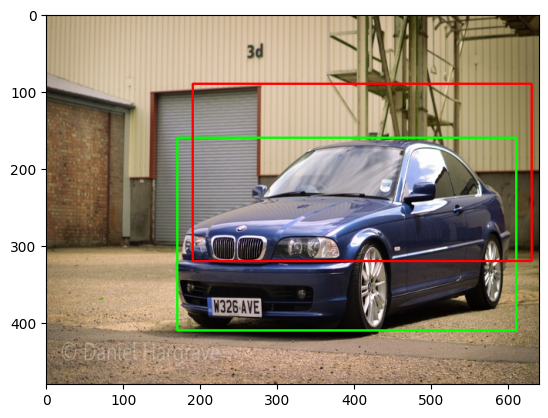

In [26]:
# reading the image
img = cv2.imread("test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# green bbox; its the ground truth bounding box
cv2.rectangle(img, (170,160), (610, 410), (0, 255, 0), 2)
# red bbox; its the predicted bounding box
cv2.rectangle(img, (190,90), (630, 320), (255, 0, 0), 2)

plt.imshow(img)

In [27]:
# Define two example bounding boxes (format: x1, y1, x2, y2)
box1 = torch.tensor([170.0, 160.0, 610.0, 410.0])
box2 = torch.tensor([190.0,90.0, 630.0, 320.0])

# Instantiate the SIoU loss function
siou_loss = SIoU()

# Calculate the loss by passing the input bounding boxes through the loss function
loss = siou_loss(box1, box2)

print("SIoU Loss:", loss.item())

SIoU Loss: 0.5849164724349976
